In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# ------------------------------
# 1. Dataset Class
# ------------------------------
class MURADataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0].replace("\\", "/")
        label = int(self.data.iloc[idx, 1])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# ------------------------------
# 2. Data Transforms
# ------------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ------------------------------
# 3. Load Dataset
# ------------------------------
train_csv = r"Datasets\MURA-v1.1\train_complete_path_images.csv"  # path to your train csv
val_csv = r"Datasets\MURA-v1.1\valid_complete_path_images.csv"     # Path to your val CSV

train_dataset = MURADataset(train_csv, transform=train_transform)
val_dataset = MURADataset(val_csv, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

# ------------------------------
# 4. Model Setup
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)  # Binary classification
model = model.to(device)

# ------------------------------
# 5. Loss and Optimizer
# ------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# ------------------------------
# 6. Mixed-Precision Training
# ------------------------------
scaler = torch.cuda.amp.GradScaler()

# ------------------------------
# 7. Training Function
# ------------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_acc = val_correct / val_total
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_mobilenetv3_mura.pth")
            print("Saved Best Model!")

    # Final metrics
    print("\n=== Final Evaluation ===")
    print(classification_report(all_labels, all_preds))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

# ------------------------------
# 8. Start Training
# ------------------------------
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15)


C:\Users\Avijeet\AppData\Local\Temp\ipykernel_8564\2998618752.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/15 [Training]:   0%|          | 0/1151 [00:00<?, ?it/s]C:\Users\Avijeet\AppData\Local\Temp\ipykernel_8564\2998618752.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/15 [Validation]:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Avijeet\AppData\Local\Temp\ipykernel_8564\2998618752.py:126: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/15 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


Epoch [1/15], Train Loss: 0.4961, Train Acc: 0.7664, Val Acc: 0.7835
Saved Best Model!


Epoch 2/15 [Validation]: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch [2/15], Train Loss: 0.4304, Train Acc: 0.8112, Val Acc: 0.8067
Saved Best Model!


Epoch 3/15 [Validation]: 100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


Epoch [3/15], Train Loss: 0.4004, Train Acc: 0.8275, Val Acc: 0.8023


Epoch 4/15 [Validation]: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


Epoch [4/15], Train Loss: 0.3773, Train Acc: 0.8389, Val Acc: 0.8201
Saved Best Model!


Epoch 5/15 [Validation]: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


Epoch [5/15], Train Loss: 0.3509, Train Acc: 0.8509, Val Acc: 0.8073


Epoch 6/15 [Validation]: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


Epoch [6/15], Train Loss: 0.3044, Train Acc: 0.8699, Val Acc: 0.8201


Epoch 7/15 [Validation]: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch [7/15], Train Loss: 0.2774, Train Acc: 0.8809, Val Acc: 0.8217
Saved Best Model!


Epoch 8/15 [Validation]: 100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


Epoch [8/15], Train Loss: 0.2563, Train Acc: 0.8920, Val Acc: 0.8126


Epoch 9/15 [Validation]: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch [9/15], Train Loss: 0.2343, Train Acc: 0.8996, Val Acc: 0.8158


Epoch 10/15 [Validation]: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


Epoch [10/15], Train Loss: 0.2122, Train Acc: 0.9122, Val Acc: 0.8123


Epoch 11/15 [Validation]: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch [11/15], Train Loss: 0.1811, Train Acc: 0.9252, Val Acc: 0.8120


Epoch 12/15 [Validation]: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch [12/15], Train Loss: 0.1636, Train Acc: 0.9340, Val Acc: 0.8104


Epoch 13/15 [Validation]: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


Epoch [13/15], Train Loss: 0.1523, Train Acc: 0.9385, Val Acc: 0.8114


Epoch 14/15 [Validation]: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch [14/15], Train Loss: 0.1432, Train Acc: 0.9411, Val Acc: 0.8064


Epoch 15/15 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Epoch [15/15], Train Loss: 0.1356, Train Acc: 0.9451, Val Acc: 0.8098

=== Final Evaluation ===
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1667
           1       0.84      0.75      0.79      1530

    accuracy                           0.81      3197
   macro avg       0.81      0.81      0.81      3197
weighted avg       0.81      0.81      0.81      3197

Confusion Matrix:
[[1443  224]
 [ 384 1146]]


## MobileNetV3 Large Result

Model loaded successfully!

=== Classification Report ===

              precision    recall  f1-score   support

    Negative       0.79      0.89      0.84      1667
    Positive       0.86      0.74      0.80      1530

    accuracy                           0.82      3197
   macro avg       0.83      0.82      0.82      3197
weighted avg       0.83      0.82      0.82      3197



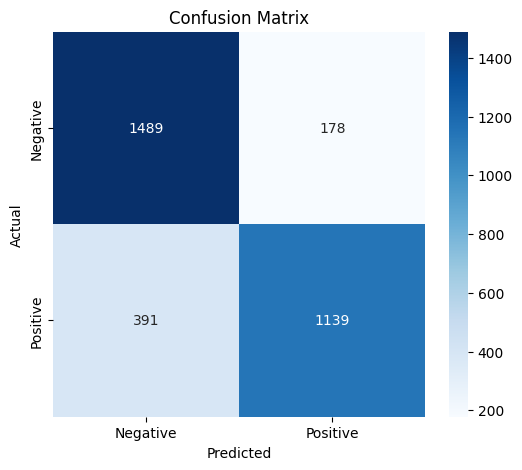


⚠️ training_metrics.pth NOT FOUND
Graphs will not load. Re-train with metric saving enabled!



NameError: name 'train_losses' is not defined

<Figure size 800x500 with 0 Axes>

: 

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# -----------------------------------
# 1. Import your model + dataset
# -----------------------------------
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import torch.nn as nn

# ------------------------------
# Dataset Loader
# ------------------------------
class MURADataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0].replace("\\", "/")
        label = int(self.data.iloc[idx, 1])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ------------------------------
# Transforms
# ------------------------------
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ------------------------------
# Load Validation Dataset
# ------------------------------
val_csv = r"Datasets\MURA-v1.1\valid_complete_path_images.csv"
val_dataset = MURADataset(val_csv, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ------------------------------
# Load Model
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v3_large(weights=None)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
model.load_state_dict(torch.load("best_mobilenetv3_mura.pth"))
model.to(device)
model.eval()

print("Model loaded successfully!")

# ------------------------------
# 2. Collect Predictions
# ------------------------------
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# ------------------------------
# 3. Classification Report
# ------------------------------
print("\n=== Classification Report ===\n")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

# ------------------------------
# 4. Confusion Matrix Plot
# ------------------------------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ================================================================
# 5. TRAINING CURVES (Load Saved Lists)
# ================================================================

# ⚠️ Make sure these lists were saved during training
# Example: torch.save([train_losses, val_losses, train_accs, val_accs], "training_metrics.pth")

try:
    train_losses, val_losses, train_accs, val_accs = torch.load("training_metrics.pth")
except:
    print("\n⚠️ training_metrics.pth NOT FOUND")
    print("Graphs will not load. Re-train with metric saving enabled!\n")
    exit()


# ------------------------------
# Loss Curve
# ------------------------------
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Accuracy Curve
# ------------------------------
plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
